In [1]:
from Neuron_analysis_tool.Analyzer import Analyzer, long_pulse_protocol
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


## Loading rall model

In [2]:
analyser = Analyzer(type='L5PC')

## plot the cell morphology

optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 104497.72it/s]


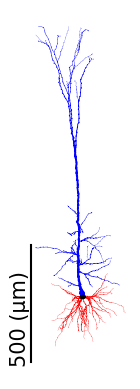

In [3]:
_,_,_=analyser.plot_morph(scale=500, diam_factor=0.5, theta=-90, ignore_soma=True)

### adding a protocol of random synapses

In [4]:
def add_syn(seg, g_AMPA=0.0004, g_NMDA=0.0004):
    netstim = h.NetStim()
    netstim.interval = 400 # fr of 1
    netstim.start = 400
    netstim.noise = 0.3
    netstim.number = 0
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = 0
    AMPA.tau1 = 0.3
    AMPA.tau2 = 1.5
    AMPA_con.weight[0] = g_AMPA
    AMPA_con.delay = 0

    # NMDA part
    NMDA=h.NMDA(seg.x, sec=seg.sec)
    NMDA_con = h.NetCon(netstim, NMDA)
    NMDA.e = 0
    NMDA.tau_r_NMDA = 8
    NMDA.tau_d_NMDA = 35
    NMDA.n_NMDA = 0.27
    NMDA.gama_NMDA = 0.076
    NMDA_con.weight[0] = g_NMDA
    NMDA_con.delay = 0
    return [AMPA, AMPA_con], [NMDA, NMDA_con], netstim

def add_isyn(seg, g_GABA=0.0004):
    netstim = h.NetStim()
    netstim.interval = 500 # fr of 1
    netstim.start = 400
    netstim.noise = 1.0
    netstim.number = 0
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = -100
    AMPA.tau1 = 0.2
    AMPA.tau2 = 4
    AMPA_con.weight[0] = g_GABA
    AMPA_con.delay = 0

    return [AMPA, AMPA_con], netstim


def random_syn_protocol(cell, start_seg):
    syns = []
    isyns = []
    segs_e = []
    syn_e_times = []
    
    segs_i = []
    syn_i_times = []
    
    total_time = 1400
    start_time=400
    number_of_e_syns = 5000
    number_of_i_syns = 2000
    
    amp=0
    e_FR = 2 #Hz
    i_FR = 2 #Hz
    #difining the synapses times
    sim_time = total_time-start_time 
    for sec in np.random.choice(list(cell.all), number_of_e_syns):
        
        seg_num = np.random.randint(0, len(list(sec)))
        segs_e.append(list(sec)[seg_num])
        syns.append(add_syn(list(sec)[seg_num]))
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*e_FR))) * sim_time
        syn_e_times.append(syn_time)

    for sec in np.random.choice(list(cell.all), number_of_i_syns):
        seg_num = np.random.randint(0, len(list(sec)))
        segs_i.append(list(sec)[seg_num])
        isyns.append(add_isyn(list(sec)[seg_num]))
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*i_FR))) * sim_time
        syn_i_times.append(syn_time)

    #function to insert synapse time to neuron
    def event_setter():
        for syn, times in zip(syns, syn_e_times):
            for t in times:
                syn[0][1].event(t) #AMPA netcon
                syn[1][1].event(t) #NMDA netcon          
        for syn, times in zip(isyns, syn_i_times):
            for t in times:
                syn[0][1].event(t) #GABA netcon
    
    # this function is return to the movie maker and is called every frame generation, than one can add stuff to the frame.
    # you must return all the new created items, so the function can call .remove() to remove this items in the next frame
    
    def draw_func1(start_time, end_time, segs, lines, ax, records):
        elements = []
        for seg, syn, times in zip(segs_e, syns, syn_e_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='r', alpha=0.75, s=10))
                        except:
                            pass
        for seg, syn, times in zip(segs_i, isyns, syn_i_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='b', alpha=0.75, s=10))
                        except:
                            pass
        return elements
        

    h.tstop = total_time
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    fih=h.FInitializeHandler(0, event_setter)
    h.run()
    return start_time, dict(draw_funcs=[draw_func1])

In [ ]:
show_records_from = dict()
show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
show_records_from[list(analyser.cell.apic[36])[0]] = dict(label='dend1', alpha=0.75, color='grey', size=40)

record_dict, draw_funcs = analyser.record_protocol(protocol=random_syn_protocol, cut_start_ms=None, record_name='v')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=0.5, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict(), 
                                           draw_funcs=draw_funcs)
animation.ipython_display(fps=10, loop=True, autoplay=True)


optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 106404.81it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:   4%|█████▋                                                                                                                                                      | 19/526 [00:05<02:37,  3.22it/s, now=None]

In [ ]:
# show_records_from = dict()
# show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
# show_records_from[list(analyser.cell.apic[36])[0]] = dict(label='dend1', alpha=0.75, color='grey', size=40)

# record_dict, draw_funcs = analyser.record_protocol(protocol=random_syn_protocol, cut_start_ms=None, record_name='v')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=None, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict(), 
                                           draw_funcs=draw_funcs, base_plot_type='dendogram', figsize=(10,10))
animation.ipython_display(fps=10, loop=True, autoplay=True)


## finding Ca spikes

In [11]:
def Ca_spike_protocol(cell, start_seg):
    delay=400.0
    stim = h.IClamp(0.5, sec=cell.soma[0])
    stim.dur   = 5
    stim.delay = delay

    syn = h.epsp(cell.apic[36](0.9))
    syn.tau0  = 0.5
    syn.tau1 = 5
    syn.onset   = stim.delay + 5
    syn.imax = 0.5 
    stim.amp = 1.9
    
    h.tstop = 700
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    h.run()
    
    
    def draw_func1(start_time, end_time, segs, lines, ax, records):
        if start_time >= end_time: return []
        elements = []
        for seg, l in zip(segs, lines):
            if records.is_existing(seg):
                r = records.get_record_at_dt(seg, start_time, end_time, dt_func = lambda x: np.max(x))
                if r > 0.00015:
                    elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='r', alpha=0.75, s=100))
        return elements
        

    return 400, dict(draw_funcs=[draw_func1])

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 97727.48it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


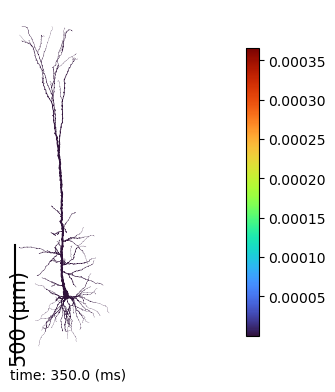

In [12]:
show_records_from = dict()

record_dict, draw_funcs = analyser.record_protocol(protocol=Ca_spike_protocol, cut_start_ms=None, 
                                          record_name='gCa_LVAst_Ca_LVAst')

animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=0.5, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict(),
                                          draw_funcs=draw_funcs)

animation.ipython_display(fps=10, loop=True, autoplay=True)